### **Time of the Day Image Classification using efficientnet_v2**.

* model used: efficientnet_v2_b0
* pretrained on: ImageNet (21K) & fine-tuned on Imagenet (1K)
* new dataset: time of the day images 
* new classes: 3 (daytime,nightime,sunrise)
* input image size: 224 x 224

In [2]:
conda create --name tf_env


ValueError: The python kernel does not appear to be a conda environment.  Please use ``%pip install`` instead.

In [5]:
# standard libraries
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pylab as plt
import matplotlib.image as mpimg
%matplotlib inline
import datetime
#from tqdm.keras import TqdmCallback
from skimage import transform
import urllib
import os
from tensorflow import keras
# tensorflow libraries
import tensorflow as tf
import tensorflow_hub as hub

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
# path variables
train_path = '/kaggle/input/timeofdaydataset'

# define image shape & batch size
batch_size = 64
img_height = 224
img_width = 224
seed_train_validation = 1 
shuffle_value = True
validation_split = 0.1


# load training images
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=validation_split,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  seed = seed_train_validation,
  shuffle = shuffle_value )

# load validation images
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed = seed_train_validation,
    shuffle = shuffle_value )

Found 2671 files belonging to 3 classes.
Using 2404 files for training.
Found 2671 files belonging to 3 classes.
Using 267 files for validation.


In [3]:
# target class names
class_names = train_ds.class_names
print("the target classes are: ",*class_names, sep =" ,")

the target classes are:  ,daytime ,nighttime ,sunrise


In [4]:
# rescaling the images for the model
'''TensorFlow Hub's convention for image models is to expect float inputs in the [0, 1] range'''

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

'''finish the input pipeline by using buffered prefetching with Dataset.prefetch, so you can yield the data from disk without I/O blocking issues.'''
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
# get the headless model
'''TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.'''

# feature vector model
efficientnet_v2_fv = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2'
feature_extractor_model = efficientnet_v2_fv

# feature extraction layer
'''Create the feature extractor by wrapping the pre-trained model as a Keras layer with hub.KerasLayer. Use the trainable=False argument to freeze the variables, so that the training only modifies the new classifier layer'''
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(img_width, img_height, 3),
    trainable=False)

# add a classification layer
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 5,923,155
Trainable params: 3,843
Non-trainable params: 5,919,312
_________________________________________________________________


In [6]:
# compile the model
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Define Epochs
NUM_EPOCHS = 20

In [7]:
# train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=[early_stopping, TqdmCallback(verbose=0)],verbose=0)

# view model accuracy
model_acc = '{:.2%}'.format(history.history['acc'][-1])
print(f"\n Model Accuracy Reached: {model_acc}")

0epoch [00:00, ?epoch/s]


 Model Accuracy Reached: 97.92%


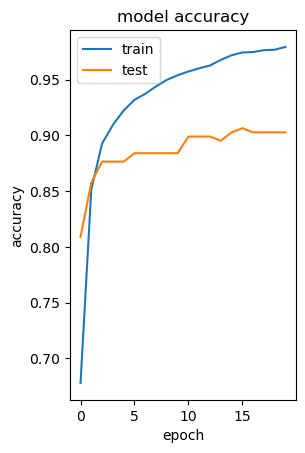

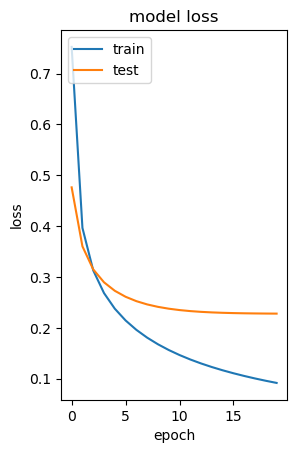

In [8]:
# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
# custom function for prediction
def image_class_prediction(url,expected_class = None):
    if os.path.exists("randomImage.jpg"):
        os.remove("randomImage.jpg")
    test_image_filename = 'randomImage.jpg'
    resource = urllib.request.urlretrieve(url, test_image_filename)
    test_img_path = '/kaggle/working/'+test_image_filename 

    test_image = Image.open(test_img_path)
    test_image = np.array(test_image).astype('float32')/255
    test_image = transform.resize(test_image, (img_width, img_height, 3))
    test_image = np.expand_dims(test_image, axis=0)

    # make predictions
    prediction = model.predict(test_image)
    pred_class = prediction.argmax()
    print(f"The Predicted Class: {class_names[pred_class]}\n")

    # view the test-image
    plt.figure(figsize=(8,8))
    test_img = mpimg.imread(test_img_path)
    plt.imshow(test_img)
    plt.title("predicted class: "+class_names[pred_class]+" | expected class: "+str(expected_class))
    plt.axis('off')
    plt.show()
    

In [10]:
# dictionary of random images from the internet
url_list = ['https://img.freepik.com/free-photo/forest-starry-sky-night_181624-25888.jpg', 'night sky',
            'https://img.freepik.com/free-photo/seoraksan-mountains-is-covered-by-morning-fog-sunrise-seoul-korea_335224-313.jpg', 'morning sunrise',
            'https://img.freepik.com/free-photo/shiny-tree-hill-slope-with-sunny-beams-mountain-valley-covered-with-fog_146671-19557.jpg', 'morning / daytime' ]

url_dict = {url_list[i]: url_list[i + 1] for i in range(0, len(url_list), 2)}


1/1 [==============================] - 1s 1s/step
The Predicted Class: nighttime



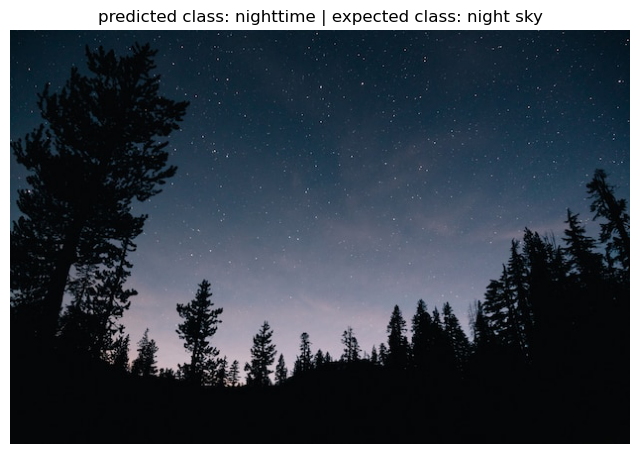

1/1 [==============================] - 0s 32ms/step
The Predicted Class: sunrise



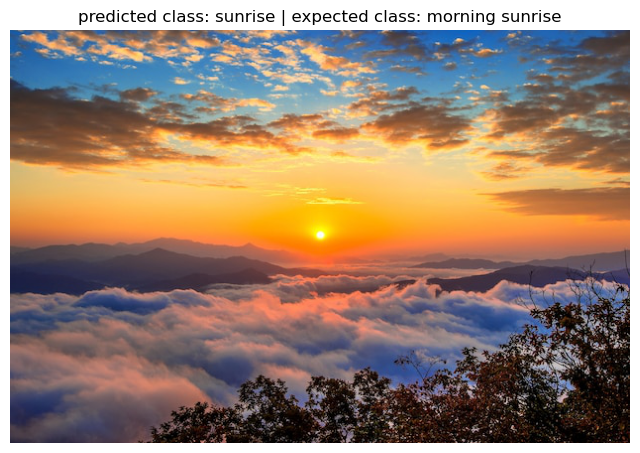

1/1 [==============================] - 0s 31ms/step
The Predicted Class: sunrise



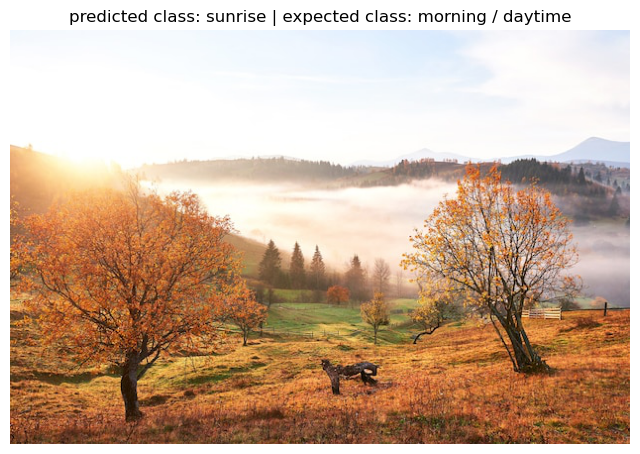

In [11]:
# iterate through the dictionary
for url,label in url_dict.items():
    image_class_prediction(url,expected_class=label)